In [1]:
# IMPORTANT: Recommended to run this notebook on Google Colab. You will need Google's MediaPipe.
# More information here: https://ai.google.dev/edge/mediapipe/solutions/vision/face_landmarker/python
!pip install mediapipe --upgrade --quiet

In [2]:
'''
INSTRUCTIONS -- This is for if you are using Google Colab. After running this cell, store all of our code and other items
in your Google Drive. If not, you may need to modify all the paths in this notebook.
'''
from google.colab import drive
drive.mount('/content/drive')

import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import cv2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import numpy as np
import os

'''
INSTRUCTIONS -- Download the face_landmarker.task if needed here: https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/latest/face_landmarker.task
Place it in your Google Drive (Or local machine if you choose), modify the path as necessary. I have included face_landmarker.task in the repository.
'''
model_path = '/content/drive/MyDrive/Colab Notebooks/face_landmarker.task'

BaseOptions = mp.tasks.BaseOptions
FaceLandmarker = mp.tasks.vision.FaceLandmarker
FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a face landmarker instance with the image mode:
options = FaceLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.IMAGE)


In [4]:
def extract_landmarks_from_image(image_path):
    # Read the image using OpenCV
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image {image_path}")
        return None  # Return None instead of zeros

    # Convert image to RGB (MediaPipe expects RGB images)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert the image to a MediaPipe Image object
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_image)

    # Perform face landmark detection
    with FaceLandmarker.create_from_options(options) as landmarker:
        face_landmarker_result = landmarker.detect(mp_image)

    # If no landmarks were detected, return None
    if not face_landmarker_result.face_landmarks:
        print(f"Warning: No face detected in {image_path}")
        return None  # Return None instead of zeros

    # Extract the first detected face’s landmarks
    face_landmarks = face_landmarker_result.face_landmarks[0]  # Take the first detected face
    landmarks_list = np.array([[lm.x, lm.y, lm.z] for lm in face_landmarks], dtype=np.float32)

    # Ensure the shape is correct
    if landmarks_list.shape != (478, 3):
        print(f"Warning: Landmark shape mismatch {landmarks_list.shape} in {image_path}, skipping...")
        return None  # Skip if incorrect shape

    return landmarks_list  # Return valid landmarks


In [5]:
import re

def natural_sort_key(s):
    """Extracts numbers from strings and sorts naturally."""
    return [int(text) if text.isdigit() else text for text in re.split(r'(\d+)', s)]

In [6]:
'''
This part is optional if you decide to use the data we already gathered from running this cell previously. No need to run if you want to skip this cell and load
our data in the next cell.

The purpose of this cell is to extract the facial landmarks on each frame using Google's MediaPipe. The code iterates through the folder of real
frames and its corresponding deepfake frame. If MediaPipe detects a face on the real frame, X_pairs will store the real frame landmarks with itself
as a pair of real-real. It will also store real-fake pairs with all the corresponding fake frame landmarks. Landmarks are 478 3-D coordinates that form a face mesh
when connected. y_pairs stores the label where real-real are 0 and real-fake are 1.

INSTRUCTIONS -- Create a folder in MyDrive and title it as "Processed DF Videos" (Or another name if desired. Adjust the base_folder path if so).
Within this folder, create a shortcut to the first 50 folders from this link: https://drive.google.com/drive/folders/1oqVJk4YxO9N4hLaH2vzZ02p6CVmZTmxg?usp=drive_link
To do so, go to the shared folder, highlight the first 50 folders, ctrl+A, right click, click "Organize", and select "Add shortcut", then select the folder you created.
'''

# # Define the base dataset directory
# base_folder = '/content/drive/MyDrive/Processed DF Videos/'

# X_pairs = []  # Stores (real_frame, fake_frame)
# y_pairs = []  # Stores similarity (0 for identical pair real-real, 1 for real-fake pairs)


# # Get the first 50 video folders
# video_folders = sorted(os.listdir(base_folder))[:50] # Limited to 50 for testing

# if len(video_folders) == 0:
#     print("No video folders found!")
# else:
#     print(f"Processing {len(video_folders)} video folders...")

#     for video_folder in video_folders:
#         video_folder_path = os.path.join(base_folder, video_folder)
#         print(f"Processing: {video_folder_path}")

#         # Get real and fake subfolders
#         real_folder = os.path.join(video_folder_path, video_folder)  # e.g., id0_0000
#         fake_folders = [f for f in os.listdir(video_folder_path) if "_id" in f]  # Fake versions

#         # 🟢 **Extract Real Landmarks Once**
#         real_landmarks_dict = {}  # Store real frame landmarks

#         if os.path.isdir(real_folder):
#             real_frames = sorted(os.listdir(real_folder), key=natural_sort_key)  # Sort properly
#             print(f"Processing real images in: {real_folder}")

#             for real_frame in real_frames:
#                 real_path = os.path.join(real_folder, real_frame)
#                 real_landmarks = extract_landmarks_from_image(real_path)  # Extract once

#                 if real_landmarks is not None:  # Skip if face not detected
#                     real_landmarks_dict[real_frame] = real_landmarks  # Store by filename
#          # 🟢 **Store (Real, Real) Pairs for Similarity Learning**
#         for real_frame in real_landmarks_dict:
#             real_landmarks = real_landmarks_dict[real_frame]

#             X_pairs.append((real_landmarks, real_landmarks))
#             y_pairs.append(0)  # Label = 0 (same)



#         # 🟢 **Now Pair with Fake Frames**
#         for fake_folder in fake_folders:
#             fake_folder_path = os.path.join(video_folder_path, fake_folder)
#             fake_frames = sorted(os.listdir(fake_folder_path), key=natural_sort_key)
#             print(f"Processing deepfake images in: {fake_folder_path}")

#             for fake_frame in fake_frames:
#                 real_frame = fake_frame  # Assume corresponding real frame has same name

#                 if real_frame in real_landmarks_dict:  # Check if we have real landmarks stored
#                     real_landmarks = real_landmarks_dict[real_frame]
#                     fake_landmarks = extract_landmarks_from_image(os.path.join(fake_folder_path, fake_frame))

#                     # 🟢 **Skip Pairs if Either Landmarks are Missing**
#                     if real_landmarks is None or fake_landmarks is None:
#                         print(f"Skipping {real_frame} due to missing landmarks.")
#                         continue  # Skip this pair

#                     # Store valid pairs
#                     X_pairs.append((real_landmarks, fake_landmarks))
#                     y_pairs.append(1)  # Always different (real vs. fake)

# # Convert to numpy arrays for storage and reuse
# X_pairs = np.array(X_pairs)
# y_pairs = np.array(y_pairs)

# print(f"Extracted {len(X_pairs)} valid pairs of real and fake frames from {len(video_folders)} video folders.")

'\nThis part is optional if you decide to use the data we already gathered from running this cell previously. No need to run if you want to skip this cell and load\nour data in the next cell. \n\nThe purpose of this cell is to extract the facial landmarks on each frame using Google\'s MediaPipe. The code iterates through the folder of real \nframes and its corresponding deepfake frame. If MediaPipe detects a face on the real frame, X_pairs will store the real frame landmarks with itself \nas a pair of real-real. It will also store real-fake pairs with all the corresponding fake frame landmarks. Landmarks are 478 3-D coordinates that form a face mesh\nwhen connected. y_pairs stores the label where real-real are 0 and real-fake are 1.  \n\nINSTRUCTIONS -- Create a folder in MyDrive and title it as "Processed DF Videos" (Or another name if desired. Adjust the base_folder path if so).\nWithin this folder, create a shortcut to the first 50 folders from this link: https://drive.google.com/dr

In [7]:
# Save the dataset
# np.save('/content/drive/MyDrive/X_landmarks_test.npy', X_pairs)
# np.save('/content/drive/MyDrive/y_labels_test.npy', y_pairs)

# print("Saved X and y successfully!")

In [8]:
'''
INSTRUCTIONS -- If the above optional cell was skipped, then run this cell. Otherwise, this cell loads the saved extracted data that we used,
which overwrites X_pairs and y_pairs, so comment this out if you ran the optional cell above.
'''
X_pairs = np.load('/content/drive/MyDrive/X_landmarks_test.npy')
y_pairs = np.load('/content/drive/MyDrive/y_labels_test.npy')

print(f"Loaded X with shape: {X_pairs.shape}")
print(f"Loaded y with shape: {y_pairs.shape}")

Loaded X with shape: (2211, 2, 478, 3)
Loaded y with shape: (2211,)


In [9]:
import tensorflow as tf
import tensorflow.keras.backend as K

#tfa.losses.SigmoidFocalCrossEntropy

def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        # Clip predictions to avoid log(0) errors
        y_pred = K.clip(y_pred, 1e-7, 1.0 - 1e-7)

        # Compute binary cross-entropy
        bce = y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred)

        # Compute focal loss factor
        focal_weight = alpha * y_true + (1 - alpha) * (1 - y_true)
        focal_modulation = K.pow(1 - y_pred, gamma)

        # Apply focal loss
        focal_loss = -focal_weight * focal_modulation * bce
        return K.mean(focal_loss)

    return loss


In [10]:
# Not used, only for when we were testing.
def contrastive_loss(margin=1.0):
    def loss(y_true, y_pred):
        return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))
    return loss

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras import backend as K


# 🟢 **Feature Extractor Model**
from tensorflow.keras import regularizers

def build_feature_extractor(input_shape):
    model = models.Sequential([
        layers.Conv1D(64, 3, activation='relu', padding='same', input_shape=input_shape,
                      kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(0.3),  # Dropout to reduce overfitting

        layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(0.3),

        layers.Conv1D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        #layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        #layers.Dropout(0.3),  # More dropout
        layers.Dropout(0.7)
    ])
    return model


# 🟢 **Siamese Network**
input_shape = (478, 3)  # 478 landmarks, 3 coordinates

real_input = Input(shape=input_shape)
fake_input = Input(shape=input_shape)

feature_extractor = build_feature_extractor(input_shape)

real_features = feature_extractor(real_input)
fake_features = feature_extractor(fake_input)


# Compute absolute difference between real & fake features
merged = layers.Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))([real_features, fake_features])
merged = layers.Dense(64, activation='relu')(merged)
merged = layers.Dense(1, activation='sigmoid')(merged)


siamese_model = models.Model(inputs=[real_input, fake_input], outputs=merged)


siamese_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=focal_loss(alpha=0.25, gamma=1.5),  # α = 0.75 for minority class, γ = 2.0 for hard examples
    #loss=contrastive_loss(margin=1.0),
    #loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)


siamese_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 478, 3)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 478, 3)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 128)            │      2,059,136 │ input_layer[0][0],     │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 128)            │              0 │ sequential[0][0],      │
│                           │                        │                │ sequential[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             65 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,067,457 (7.89 MB)

 Trainable params: 2,066,561 (7.88 MB)

 Non-trainable params: 896 (3.50 KB)

In [12]:
import numpy as np

# Convert to numpy array
X_pairs = np.array(X_pairs)
y_pairs = np.array(y_pairs)

# Print shape
print(f"X_pairs shape: {X_pairs.shape}")  # Expected: (num_samples, 2, 478, 3)
print(f"y_pairs shape: {y_pairs.shape}")  # Expected: (num_samples,)

# Check first few pairs
for i in range(5):
    print(f"Pair {i}: Real {X_pairs[i, 0].shape}, Fake {X_pairs[i, 1].shape}, Label {y_pairs[i]}")


X_pairs shape: (2211, 2, 478, 3)
y_pairs shape: (2211,)
Pair 0: Real (478, 3), Fake (478, 3), Label 0
Pair 1: Real (478, 3), Fake (478, 3), Label 0
Pair 2: Real (478, 3), Fake (478, 3), Label 0
Pair 3: Real (478, 3), Fake (478, 3), Label 0
Pair 4: Real (478, 3), Fake (478, 3), Label 0


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import numpy as np


print("Before shuffling:")
for i in range(5):
    print(f"X_pairs[{i}] = {X_pairs[i]}, y_pairs[{i}] = {y_pairs[i]}")

# Shuffle before splitting to ensure randomness
np.random.seed(42)  # Set seed for reproducibility


# Print after shuffling
print("\nAfter shuffling:")
for i in range(5):
    print(f"X_pairs[{i}] = {X_pairs[i]}, y_pairs[{i}] = {y_pairs[i]}")

#print("Unique labels in new y_test:", np.unique(y_test, return_counts=True))


# 🟢 Step 1: Split into Train (80%) and Temp (20%) BEFORE Oversampling
X_train, X_temp, y_train, y_temp = train_test_split(
    X_pairs, y_pairs, test_size=0.2, random_state=42, stratify=y_pairs
)

# 🟢 Step 2: Oversample ONLY within the Training Set
num_real_real = np.sum(y_train == 0)
num_real_fake = np.sum(y_train == 1)

if num_real_real < num_real_fake:
    X_real_real = X_train[y_train == 0]
    y_real_real = y_train[y_train == 0]

    X_real_real_oversampled, y_real_real_oversampled = resample(
        X_real_real, y_real_real, replace=True, n_samples=num_real_fake, random_state=42
    )

    # Merge back
    X_train = np.concatenate([X_train, X_real_real_oversampled])
    y_train = np.concatenate([y_train, y_real_real_oversampled])

# 🟢 Step 3: Now Split Temp into Validation (50%) and Test (50%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Extract real and fake separately
X_train_real, X_train_fake = X_train[:, 0], X_train[:, 1]
X_val_real, X_val_fake = X_val[:, 0], X_val[:, 1]
X_test_real, X_test_fake = X_test[:, 0], X_test[:, 1]

print(f"New Train Shape: {X_train.shape}, {y_train.shape}")
print(f"New Validation Shape: {X_val.shape}, {y_val.shape}")
print(f"New Test Shape: {X_test.shape}, {y_test.shape}")

Before shuffling:
X_pairs[0] = [[[ 0.5758747   0.3997088  -0.00548307]
  [ 0.5788802   0.37303716 -0.02191201]
  [ 0.57935214  0.37979436 -0.00889653]
  ...
  [ 0.61068183  0.30628535 -0.00960756]
  [ 0.6058378   0.3130331  -0.00961525]
  [ 0.60906345  0.32210565 -0.0096144 ]]

 [[ 0.5758747   0.3997088  -0.00548307]
  [ 0.5788802   0.37303716 -0.02191201]
  [ 0.57935214  0.37979436 -0.00889653]
  ...
  [ 0.61068183  0.30628535 -0.00960756]
  [ 0.6058378   0.3130331  -0.00961525]
  [ 0.60906345  0.32210565 -0.0096144 ]]], y_pairs[0] = 0
X_pairs[1] = [[[ 0.56610227  0.37557006 -0.00822109]
  [ 0.5628284   0.34770426 -0.02251483]
  [ 0.5646239   0.35527176 -0.01046167]
  ...
  [ 0.5778799   0.27030307 -0.00386668]
  [ 0.57535714  0.2785579  -0.0038756 ]
  [ 0.5793934   0.2838828  -0.0038745 ]]

 [[ 0.56610227  0.37557006 -0.00822109]
  [ 0.5628284   0.34770426 -0.02251483]
  [ 0.5646239   0.35527176 -0.01046167]
  ...
  [ 0.5778799   0.27030307 -0.00386668]
  [ 0.57535714  0.2785579  -0.

In [14]:
# Count labels before and after splitting
print("\nLabel Distribution Before Splitting:")
unique, counts = np.unique(y_pairs, return_counts=True)
print(dict(zip(unique, counts)))

print("\nLabel Distribution in Train Set:")
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

print("\nLabel Distribution in Validation Set:")
unique, counts = np.unique(y_val, return_counts=True)
print(dict(zip(unique, counts)))

print("\nLabel Distribution in Test Set:")
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))



Label Distribution Before Splitting:
{0: 474, 1: 1737}

Label Distribution in Train Set:
{0: 1768, 1: 1389}

Label Distribution in Validation Set:
{0: 47, 1: 174}

Label Distribution in Test Set:
{0: 48, 1: 174}


In [15]:
# Checking the first 5 landmarks
for i in range(5):
    print(f"Pair {i}:")
    print(f"  Real: {X_train_real[i][:5]}")  # Print first 5 landmark points
    print(f"  Fake: {X_train_fake[i][:5]}")  # Print first 5 landmark points
    print(f"  Label: {y_train[i]}")  # Should be 0 (same) or 1 (different)
    print("-" * 40)

Pair 0:
  Real: [[ 0.66068053  0.43659207 -0.0157551 ]
 [ 0.65686256  0.396118   -0.0356052 ]
 [ 0.65954703  0.4068333  -0.01750282]
 [ 0.6534873   0.35734272 -0.02794391]
 [ 0.65666187  0.38411576 -0.03863133]]
  Fake: [[ 0.66040707  0.43310076 -0.01505834]
 [ 0.65636235  0.39792395 -0.03464111]
 [ 0.6591513   0.4086548  -0.01718247]
 [ 0.6531364   0.35733905 -0.02710686]
 [ 0.6561383   0.38572347 -0.03756014]]
  Label: 1
----------------------------------------
Pair 1:
  Real: [[ 0.4807469   0.5192965  -0.00655119]
 [ 0.47787014  0.4921801  -0.02333838]
 [ 0.47958955  0.4985182  -0.01036057]
 [ 0.4731684   0.4558478  -0.02006188]
 [ 0.47721824  0.4820848  -0.02575724]]
  Fake: [[ 0.4801336   0.5156355  -0.00856145]
 [ 0.4773093   0.49232823 -0.02406665]
 [ 0.4789374   0.49821934 -0.0110922 ]
 [ 0.4727266   0.45722398 -0.01995721]
 [ 0.47673592  0.48239994 -0.02638089]]
  Label: 1
----------------------------------------
Pair 2:
  Real: [[ 0.5589435   0.53842825 -0.00777522]
 [ 0.5577

In [16]:
'''
This part is optional if you decide to use the weights we already got previously. See the next cell. If not,
you can uncomment and run this cell to train the model. You will be able to see the train and val accuracy and auc.
Make sure to comment out the next cell if so.
'''


# from tensorflow.keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(
#     monitor='val_loss',  # Stop when validation loss stops improving
#     patience=5,          # Number of epochs to wait before stopping
#     restore_best_weights=True  # Keeps the best model weights
# )


# history = siamese_model.fit(
#     [X_train_real, X_train_fake], y_train,  # Pass real & fake separately
#     validation_data=([X_val_real, X_val_fake], y_val),
#     epochs=15,
#     batch_size=16,
#     callbacks=[early_stopping]
# )


'\nThis part is optional if you decide to use the weights we already got previously. See the next cell. If not,\nyou can uncomment and run this cell to train the model. You will be able to see the train and val accuracy and auc. \nMake sure to comment out the next cell if so.\n'

In [17]:
'''
This is for if you decide to use the weights we already got previously. The paths may need to be revised depending
where you stored it.
'''
from tensorflow.keras.models import load_model

# Load the saved weights
siamese_model.load_weights("/content/drive/MyDrive/siamese.weights.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [18]:
# Test accuracy BEFORE finding the optimal threshold

test_loss, test_acc, aa = siamese_model.evaluate([X_test_real, X_test_fake], y_test)
print(f"Test Accuracy: {test_acc:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 366ms/step - accuracy: 0.7694 - auc: 0.9969 - loss: 0.0679
Test Accuracy: 0.7838


In [19]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

# Find the best threhold for determining if pairs are different (fake) or same (real). Threshold
# is determined based on validation data.
def find_best_threshold(predictions, y_true, thresholds=np.linspace(0.45, 0.6, 20)):
    best_threshold = 0.5
    best_f1 = 0

    for threshold in thresholds:
        y_pred = (predictions >= threshold).astype(int)

        f1 = f1_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)

        print(f"Threshold: {threshold:.3f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    print(f"\nBest Threshold: {best_threshold:.3f} with F1-score: {best_f1:.4f}")
    return best_threshold


pred_probs = siamese_model.predict([X_val_real, X_val_fake])  # Get probability predictions on validation set
best_threshold = find_best_threshold(pred_probs, y_val)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step
Threshold: 0.450 | F1: 0.8810 | Precision: 0.7873 | Recall: 1.0000
Threshold: 0.458 | F1: 0.8810 | Precision: 0.7873 | Recall: 1.0000
Threshold: 0.466 | F1: 0.8810 | Precision: 0.7873 | Recall: 1.0000
Threshold: 0.474 | F1: 0.8810 | Precision: 0.7873 | Recall: 1.0000
Threshold: 0.482 | F1: 0.8810 | Precision: 0.7873 | Recall: 1.0000
Threshold: 0.489 | F1: 0.8810 | Precision: 0.7873 | Recall: 1.0000
Threshold: 0.497 | F1: 0.8810 | Precision: 0.7873 | Recall: 1.0000
Threshold: 0.505 | F1: 0.8810 | Precision: 0.7873 | Recall: 1.0000
Threshold: 0.513 | F1: 0.8810 | Precision: 0.7873 | Recall: 1.0000
Threshold: 0.521 | F1: 0.8810 | Precision: 0.7873 | Recall: 1.0000
Threshold: 0.529 | F1: 0.8810 | Precision: 0.7873 | Recall: 1.0000
Threshold: 0.537 | F1: 0.9581 | Precision: 1.0000 | Recall: 0.9195
Threshold: 0.545 | F1: 0.8882 | Precision: 1.0000 | Recall: 0.7989
Threshold: 0.553 | F1: 0.8361 | Precision: 1.0000 | Recall: 0.7184
Threshold: 0.561 | F1: 

In [20]:
import numpy as np


# Make predictions
predictions = siamese_model.predict([X_test_real, X_test_fake])

# Print results for first 3 test pairs
for i in range(3):
    real_landmarks = X_test_real[i]
    fake_landmarks = X_test_fake[i]
    similarity_score = predictions[i][0]
    print(real_landmarks)
    print(fake_landmarks)

    print(f"Test Pair {i}: Predicted Similarity Score = {similarity_score:.4f}")

    # Interpretation
    if similarity_score < best_threshold:
        print("Prediction: Likely the same person (REAL)")
    else:
        print("Prediction: Likely a deepfake (FAKE)")

    print("-" * 40)  # Separate results


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
[[ 0.4119208   0.4860013  -0.04125797]
 [ 0.39825404  0.44187814 -0.06742574]
 [ 0.40800357  0.45668328 -0.03760568]
 ...
 [ 0.47470933  0.36212656 -0.00704392]
 [ 0.46493495  0.37140495 -0.00705854]
 [ 0.47624362  0.37968856 -0.00705659]]
[[ 0.45397156  0.47117642 -0.04467094]
 [ 0.44050646  0.4244794  -0.06853858]
 [ 0.4487967   0.44011998 -0.03942602]
 ...
 [ 0.51084805  0.3474459   0.00142586]
 [ 0.50025165  0.35728186  0.00141165]
 [ 0.5123971   0.3652708   0.00141357]]
Test Pair 0: Predicted Similarity Score = 0.9989
Prediction: Likely a deepfake (FAKE)
----------------------------------------
[[ 0.50807303  0.3780566  -0.00861267]
 [ 0.50774425  0.35193884 -0.02502949]
 [ 0.50846994  0.3578846  -0.01091282]
 ...
 [ 0.5360448   0.2696463  -0.00549321]
 [ 0.5317055   0.27732456 -0.00550052]
 [ 0.53581274  0.2857006  -0.00549998]]
[[ 0.50689995  0.37958705 -0.0105569 ]
 [ 0.50628334  0.34911013 -0.02619892]
 [ 0.50706214  0.3566673  -0.01227238

In [21]:
from sklearn.metrics import accuracy_score, classification_report


In [22]:
# Metrics AFTER finding best threshold

# Convert predictions to binary labels (0 = real, 1 = fake)
predicted_labels = (predictions >= best_threshold).astype(int).flatten()

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"✅ Test Accuracy: {accuracy:.4f}")

# Print classification report
print(classification_report(y_test, predicted_labels, target_names=["Real", "Fake"]))


✅ Test Accuracy: 0.9505
              precision    recall  f1-score   support

        Real       0.81      1.00      0.90        48
        Fake       1.00      0.94      0.97       174

    accuracy                           0.95       222
   macro avg       0.91      0.97      0.93       222
weighted avg       0.96      0.95      0.95       222



[[ 48   0]
 [ 11 163]]


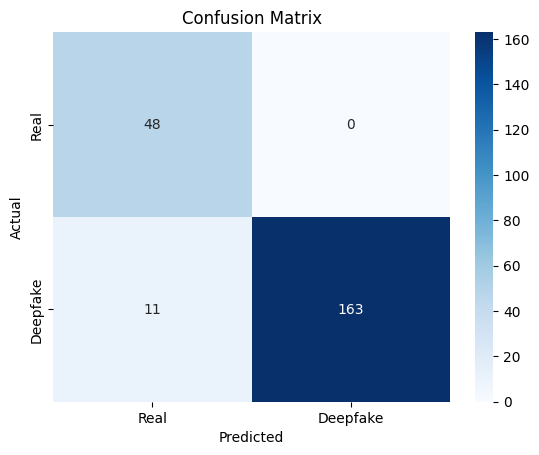

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predicted_labels)
print(cm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Real', 'Deepfake'], yticklabels=['Real', 'Deepfake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [24]:
# siamese_model.save("/content/drive/MyDrive/siamese_model_small.h5")
# siamese_model.save_weights("/content/drive/MyDrive/siamese.weights.h5")